# Load tapes and lob data

do this for each day otherwise memory (RAM) exceeds most computers

In [ ]:
# code
from fast_tools import get_data, get_data_gen

#data = get_data()

# Clean Data
Remove outliers from lob and create an additional columns noting this

FFill tapes data to get the most up to date tapes price

In [ ]:
# code
import numpy as np
from numba import njit, prange

def get_tapes_window(tapes):
    dt = 60*60 # in seconds
    #stds = []
    #means = []
    w_bids = []
    w_asks = []

    t_start = 0
    start_time = 0
    z = 3.29 # 99.9%

    outside = []
    while True:
        end_time = start_time + dt
        t_end = t_start
        rolling_tapes = []
        while tapes[t_end, 0] < end_time:
            rolling_tapes += [tapes[t_end, 1]] * int(tapes[t_end,2])
            t_end += 1

        mean = np.mean(rolling_tapes)
        std = np.std(rolling_tapes)
        #means.append(mean)

        w_bid = mean - std * z
        w_ask = mean + std * z
        w_bids.append(w_bid)
        w_asks.append(w_ask)

        # look one minute a head
        local_end = t_end
        future_tapes = []
        while tapes[local_end, 0] < end_time + 60:
            future_tapes += [tapes[local_end, 1]] * int(tapes[local_end,2])
            local_end += 1

        future_tapes = np.array(future_tapes)

        n_above = len(np.where(future_tapes > w_ask)[0])
        n_below = len(np.where(future_tapes < w_bid)[0])
        if end_time % 60 !=0:
            raise ValueError
        outside.append((end_time,n_above, n_below, len(future_tapes)))

        start_time += 60
        while tapes[t_start, 0] < start_time:
            t_start += 1

        end_time += dt
        if end_time >= 8.5*60*60:
            break

    return outside, w_bids, w_asks

@njit(parallel=True)
def get_features(lob_data: np.array, 
                 lob_times: np.array, 
                 tapes: np.array, 
                 time_step_s: int, 
                 window_data: np.array,
                 ab_weight = 1, 
                 median = False, 
                 ):
    """
    Calculate features from LOB and Tapes data.

    Parameters:
    -----------
    lob_data : np.array
        Array containing the limit order book (LOB) data.
    lob_times : np.array
        Array containing timestamps for the LOB data.
    tapes : np.array
        Array containing Tapes data.
    time_step_s : int
        Time step in seconds for calculating features.
    ab_weight : float, optional
        Weight parameter for alpha and beta calculations, by default 1.
    median : bool, optional
        Whether to calculate features using median instead of mean, by default False.
    cas_cbs_window : int, optional
        Size of the window for calculating CAS and CBS, by default 800.
    daily_data : bool, optional
        Whether to calculate daily features, by default False.

    Returns:
    --------
    tuple
        A tuple containing:
        - feat_arr: np.array
            Array containing feature values.
        - features: list
            List of feature names.
        - daily_arr: dict or None
            Dictionary containing daily features or None if daily_data=False.
    """
    
    n_rows = int((8.5 * 60 * 60) / time_step_s)                         # define number of rows of output array
    features = ["MP","HIBID","LOASK","AP","WBP","WAP",                  # define features
                "TCBS","TCAS","AWS","VOL","GAP","SPREAD",
                "ALPHA", "BETA", "ZETA", "ENDT", 
                "PSTD", "LOWIN", "HIWIN", "nUoD"]
    n_features = len(features)                                          # define number of features

    feat_arr = np.zeros((n_rows, n_features), dtype=np.float64)         # array to hold feature values
    
    LA_HB_a_b = np.zeros((lob_data.shape[0]+1, 4), dtype = np.float64)  # array holding the LOASK, HIBID,
                                                                        # alpha, beta, values 

    for i in prange(lob_data.shape[0]):                                 # iterates over the LOB to fill
        row = lob_data[i]                                               # LA_HB_a_b values
        
        neg_ind = np.where(row < 0)[0]                                  # locate bid and ask prices (indicies)
        pos_ind = np.where(row > 0)[0]
        
        if len(neg_ind) == 0:                                           # assign HIBID, np.nan if no values
            LA_HB_a_b[i][1] = np.nan
        else:
            LA_HB_a_b[i][1] = max(neg_ind) + 1 

        if len(pos_ind) == 0:                                           # assign HIBID, np.nan if no values
            LA_HB_a_b[i][0] = np.nan
        else:
            LA_HB_a_b[i][0] = min(pos_ind) + 1

        mid_price = (LA_HB_a_b[i][0] + LA_HB_a_b[i][1]) / 2             # calculate mid_price for alpha/beta calculations

        if np.isnan(mid_price):
            alpha = np.nan
            beta = np.nan
        else:                                                           # calculate alpha/beta using ab_weight var
            beta = 0
            for ind in neg_ind:
                beta += (-1 * row[ind]) / ((mid_price - (ind + 1)) + ab_weight)
    
            alpha = 0
            for ind in pos_ind:
                alpha += row[ind] / (((ind + 1) - mid_price) + ab_weight)
                

        LA_HB_a_b[i][2] = alpha
        LA_HB_a_b[i][3] = beta
        
    max_lob = lob_data.shape[0] - 1                                      # define max indicies for lob
    max_tapes = tapes.shape[0] - 1                                       # define max indicies for tapes
    
    start_time = 0                                                       # define start time
    lob_start = 0                                                        # define start index for lob
    tapes_start = 0                                                      # define start index for tapes
    
    cas = np.zeros(800, dtype = np.int16)                                # define an array to hold CAS values
    cbs = np.zeros(800, dtype = np.int16)                                # define an array to hold CBS values
    for row_i in range(n_rows):
        end_time = start_time + time_step_s                              # move to next time step
        lob_end = lob_start
        tapes_end = tapes_start

        # get lob end index
        while lob_times[lob_end] < end_time and lob_end < max_lob:       # move lob indicies to end time
            lob_end += 1
        
        # get tapes end index
        while tapes[tapes_end][0] < end_time and tapes_end < max_tapes:  # move tapes indicies to end time
            tapes_end += 1

        # feature calculations
        if tapes_start == tapes_end:                                     # if there is no tapes data
            AP = np.nan                                                  # set tapes features to np.nan
            VOL = np.nan
            PSTD = np.nan
            nUoD = np.nan
        else:
            tapes_slice = tapes[tapes_start:tapes_end]                   # extract tapes slice, calculate AP, VOL
            tapes_list = []
            
            for row in tapes_slice:
                for _ in range(int(row[2])):
                    tapes_list.append(row[1])

            tapes_list = np.array(tapes_list, dtype=np.int32)
            AP = np.mean(tapes_list)
            VOL = np.sum(tapes_slice[:,2])
            PSTD = np.std(tapes_list)

            tapes_price_diff = tapes_slice[:,1][1:] - tapes_slice[:,1][:-1]
            n_ups = np.sum(tapes_price_diff > 0)
            n_downs = np.sum(tapes_price_diff < 0)
            nUoD = (n_ups + 1) / (n_downs + 1) - 1

        if lob_start == lob_end:                                         # if there is no LOB data
            MP = np.nan                                                  # set lob features to np.nan
            HIBID = np.nan
            LOASK = np.nan
            SPREAD = np.nan
            TCBS = np.nan
            TCAS = np.nan
            WBP = np.nan
            WAP = np.nan
            AWS = np.nan
            ALPHA = np.nan
            BETA = np.nan
            ZETA = np.nan  
        else:
            lob_slice = lob_data[lob_start:lob_end]                       # extract slices of data 
            LA_HB_a_b_slice = LA_HB_a_b[lob_start:lob_end]                

            # midprice_calcs, alpha, beta
            if median:                                                    # calculate price features
                HIBID = np.median(LA_HB_a_b_slice[:,1])                   # using median if set to true
                LOASK = np.median(LA_HB_a_b_slice[:,0])
                ALPHA = np.median(LA_HB_a_b_slice[:,2])
                BETA = np.median(LA_HB_a_b_slice[:,3])
            else:
                HIBID = np.nanmean(LA_HB_a_b_slice[:,1])
                LOASK = np.nanmean(LA_HB_a_b_slice[:,0])
                ALPHA = np.nanmean(LA_HB_a_b_slice[:,2])
                BETA = np.nanmean(LA_HB_a_b_slice[:,3])

            MP = (HIBID + LOASK) / 2
            SPREAD = LOASK - HIBID
            ZETA = BETA - ALPHA

            if HIBID >= LOASK:
                print("WARNING: HIBID >= LOASK")

            # consolidated calcs
            cas[:] = 0                                                      # reset cas, cbs arrays for new data
            cbs[:] = 0 

            window_index = np.where(window_data[:,0] == end_time)[0]
            if len(window_index) == 1:
                w_bid = window_data[window_index[0], 4]
                w_ask = window_data[window_index[0], 5]
                LOWIN = window_data[window_index[0], 1]
                HIWIN = window_data[window_index[0], 2]
            else:
                w_bid = MP - 100
                w_ask = MP + 100
                LOWIN = 0
                HIWIN = 0

            for ci in prange(int(np.floor(w_bid) - 1), int(np.ceil(w_ask) + 2)):
                # can optimise with LOASK AND HIBID here
                                                                        # only calculate cbs between window left of MP
                cbs_vec = lob_slice[:,ci].copy() * -1                   # and less than LOASK + 100 for efficiency
                cbs_vec[cbs_vec <= 0] = 0                               # idk if this breaks things for efficiency ?:
                cbs[ci] = np.sum(np.abs(np.diff(cbs_vec))) + cbs_vec[0]

                                                                        # only calculate cas between window right of MP
                cas_vec = lob_slice[:,ci].copy()                        # and greater than HIBID - 100 for efficiency
                cas_vec[cas_vec <= 0] = 0                               # idk if this breaks things for efficiency ?:
                cas[ci] = np.sum(np.abs(np.diff(cas_vec))) + cas_vec[0]

            TCBS = np.sum(cbs)                                              # Total CBS
            TCAS = np.sum(cas)                                              # Total CAS

            if TCBS == 0:                                                   # Calculate WBP, np.nan if no activity
                WBP = np.nan
            else:
                WBP = 0
                for ci in prange(800):
                    WBP += (ci + 1) * (cbs[ci] / TCBS)

            if TCAS == 0:                                                   # Calculate WAP, np.nan if no activity
                WAP = np.nan
            else:
                WAP = 0
                for ci in prange(800):
                    WAP += (ci + 1) * (cas[ci] / TCAS)

            AWS = WAP - WBP                                                 # Activity weighted spread calc

        # feature setting
        feat_arr[row_i][features.index("AP")] = AP                          # set the values to the feat_arr
        feat_arr[row_i][features.index("VOL")] = VOL
        feat_arr[row_i][features.index("MP")] = MP
        feat_arr[row_i][features.index("HIBID")] = HIBID
        feat_arr[row_i][features.index("LOASK")] = LOASK
        feat_arr[row_i][features.index("SPREAD")] = SPREAD
        feat_arr[row_i][features.index("TCAS")] = TCAS
        feat_arr[row_i][features.index("TCBS")] = TCBS
        feat_arr[row_i][features.index("WAP")] = WAP
        feat_arr[row_i][features.index("WBP")] = WBP
        feat_arr[row_i][features.index("AWS")] = AWS
        feat_arr[row_i][features.index("ALPHA")] = ALPHA
        feat_arr[row_i][features.index("BETA")] = BETA
        feat_arr[row_i][features.index("ZETA")] = ZETA
        feat_arr[row_i][features.index("GAP")] = MP - AP
        feat_arr[row_i][features.index("ENDT")] = end_time
        feat_arr[row_i][features.index("PSTD")] = PSTD
        feat_arr[row_i][features.index("LOWIN")] = LOWIN
        feat_arr[row_i][features.index("HIWIN")] = HIWIN
        feat_arr[row_i][features.index("nUoD")] = nUoD


        # adjust start times
        start_time = end_time                                                # Set the next start times and 
        lob_start = lob_end                                                  # indicies to the last end times / indicies
        tapes_start = tapes_end

    return feat_arr, features

c = 0
all_features = []
for lob, lob_times, tapes in get_data_gen():
    print(c, end = "\r")
    outside, w_bids, w_asks = get_tapes_window(tapes)
    window_data = np.zeros((len(outside), 6), dtype = float)
    for i in range(len(outside)):
        window_data[i][:4] = outside[i]
        window_data[i][4] = w_bids[i]
        window_data[i][5] = w_asks[i]

    features = get_features(lob, lob_times, tapes, 15, window_data)
    all_features.append(features)
    c += 1

In [ ]:
import pandas as pd

dfs = [pd.DataFrame(fa, columns=f) for fa, f in all_features]

for df in dfs:
    df["WMP"] = (df["WBP"] + df["WAP"]) / 2
    df["MP_diff(y)"] = df["MP"].diff(1).shift(-1)
df.describe()

In [ ]:
df

# Extract features from LOB and Tapes

get mean, std, trend, delta from 60 min segments

In [ ]:
# code

features = ["TCAS", "TCBS", "ALPHA", "BETA", "ZETA",
            "WMP", "AWS", "VOL", "GAP", "nUoD", "PSTD"]

sum_features = ["LOWIN", "HIWIN"]

y_feat = "MP_diff(y)"

X_dfs = []



for c, df in enumerate(dfs):
    print(c, end = "\r")

    X_df = pd.DataFrame()

    for i in range(len(df) - 60):
        train_segment = df[i:i+60]
        test_segment = df[i+60:i+61]

        row = {}
        for f in features:
            # std
            row[f+"_std"] = np.std(train_segment[f])
            # mean
            if f != "WMP": # exclude mean midprice
                row[f+"_mean"] = np.mean(train_segment[f])
                row[f+"_close"] = train_segment[f].iloc[-1]
            # delta
            row[f+"_delta"] = train_segment[f].iloc[-1] - train_segment[f].iloc[0]
            # trend
            row[f+"_corr"] = np.corrcoef(np.arange(len(train_segment[f])), train_segment[f].to_numpy())[0, 1]

        for f in sum_features:
            row[f+"_sum"] = np.sum(train_segment[f])

        row[y_feat] = test_segment[y_feat].iloc[0]
        row["ENDT"] = test_segment["ENDT"]

        X_df = pd.concat([X_df, pd.DataFrame(row)])

    X_dfs.append(X_df)

X_dfs[0]

In [ ]:
merged_dfs = pd.concat(X_dfs[:], axis = 0)

clean_merge_dfs = merged_dfs.dropna(how="any")

x_features = list(X_df)
x_features.remove(y_feat)

X = clean_merge_dfs[x_features]
y = 1 / (1 + np.exp(-clean_merge_dfs[y_feat]/4))

baseline_mae = np.mean(np.abs(y - 0.5))
print("Baseline MAE: ", baseline_mae)
print("Samples: ", len(merged_dfs))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X contains your input features and y contains your target values
# X shape: (number of samples, 35)

# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

# Step 2: Normalize the input features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

DTR = DecisionTreeRegressor(max_leaf_nodes=10)
DTR.fit(X_train, y_train)

ypred = DTR.predict(X_test)
print(mean_absolute_error(ypred, y_test))

plt.figure(figsize=(15,8))
plot_tree(DTR, feature_names=x_features)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ypred)
plt.plot(y_test.to_numpy())
plt.xlim(0,1000)

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(x_features, DTR.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

svc = SVR()
svc.fit(X_train, y_train)

ypred = SVR.predict(X_test)
print(mean_absolute_error(ypred, y_test))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

def create_regression_model(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dropout(0.2),  # Add Dropout layer
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation = 'sigmoid')  # Output layer with single neuron for regression
    ])

    opt = optimizers.Adam(learning_rate=0.05)
    model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mae'])
    return model

input_shape = (len(x_features),)
regression_model = create_regression_model(input_shape)

# Display model architecture
regression_model.summary()

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = regression_model.fit(X_train_normalized, y_train, epochs=1000, batch_size=512, validation_split=0.5, callbacks=[early_stopping])

In [ ]:
import matplotlib.pyplot as plt
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.axhline(baseline_mae, c = "black", linestyle = "--")
plt.show()

test_loss = regression_model.evaluate(X_test_normalized, y_test)
model_filename = f"regression_model_test_score_{test_loss[-1]:.4f}.keras"
regression_model.save(model_filename)
# Print the test loss
print("Test Loss:", test_loss)

# Save features

for use in models

In [ ]:
merged_dfs.to_csv("final_merged.csv")


<Axes: >

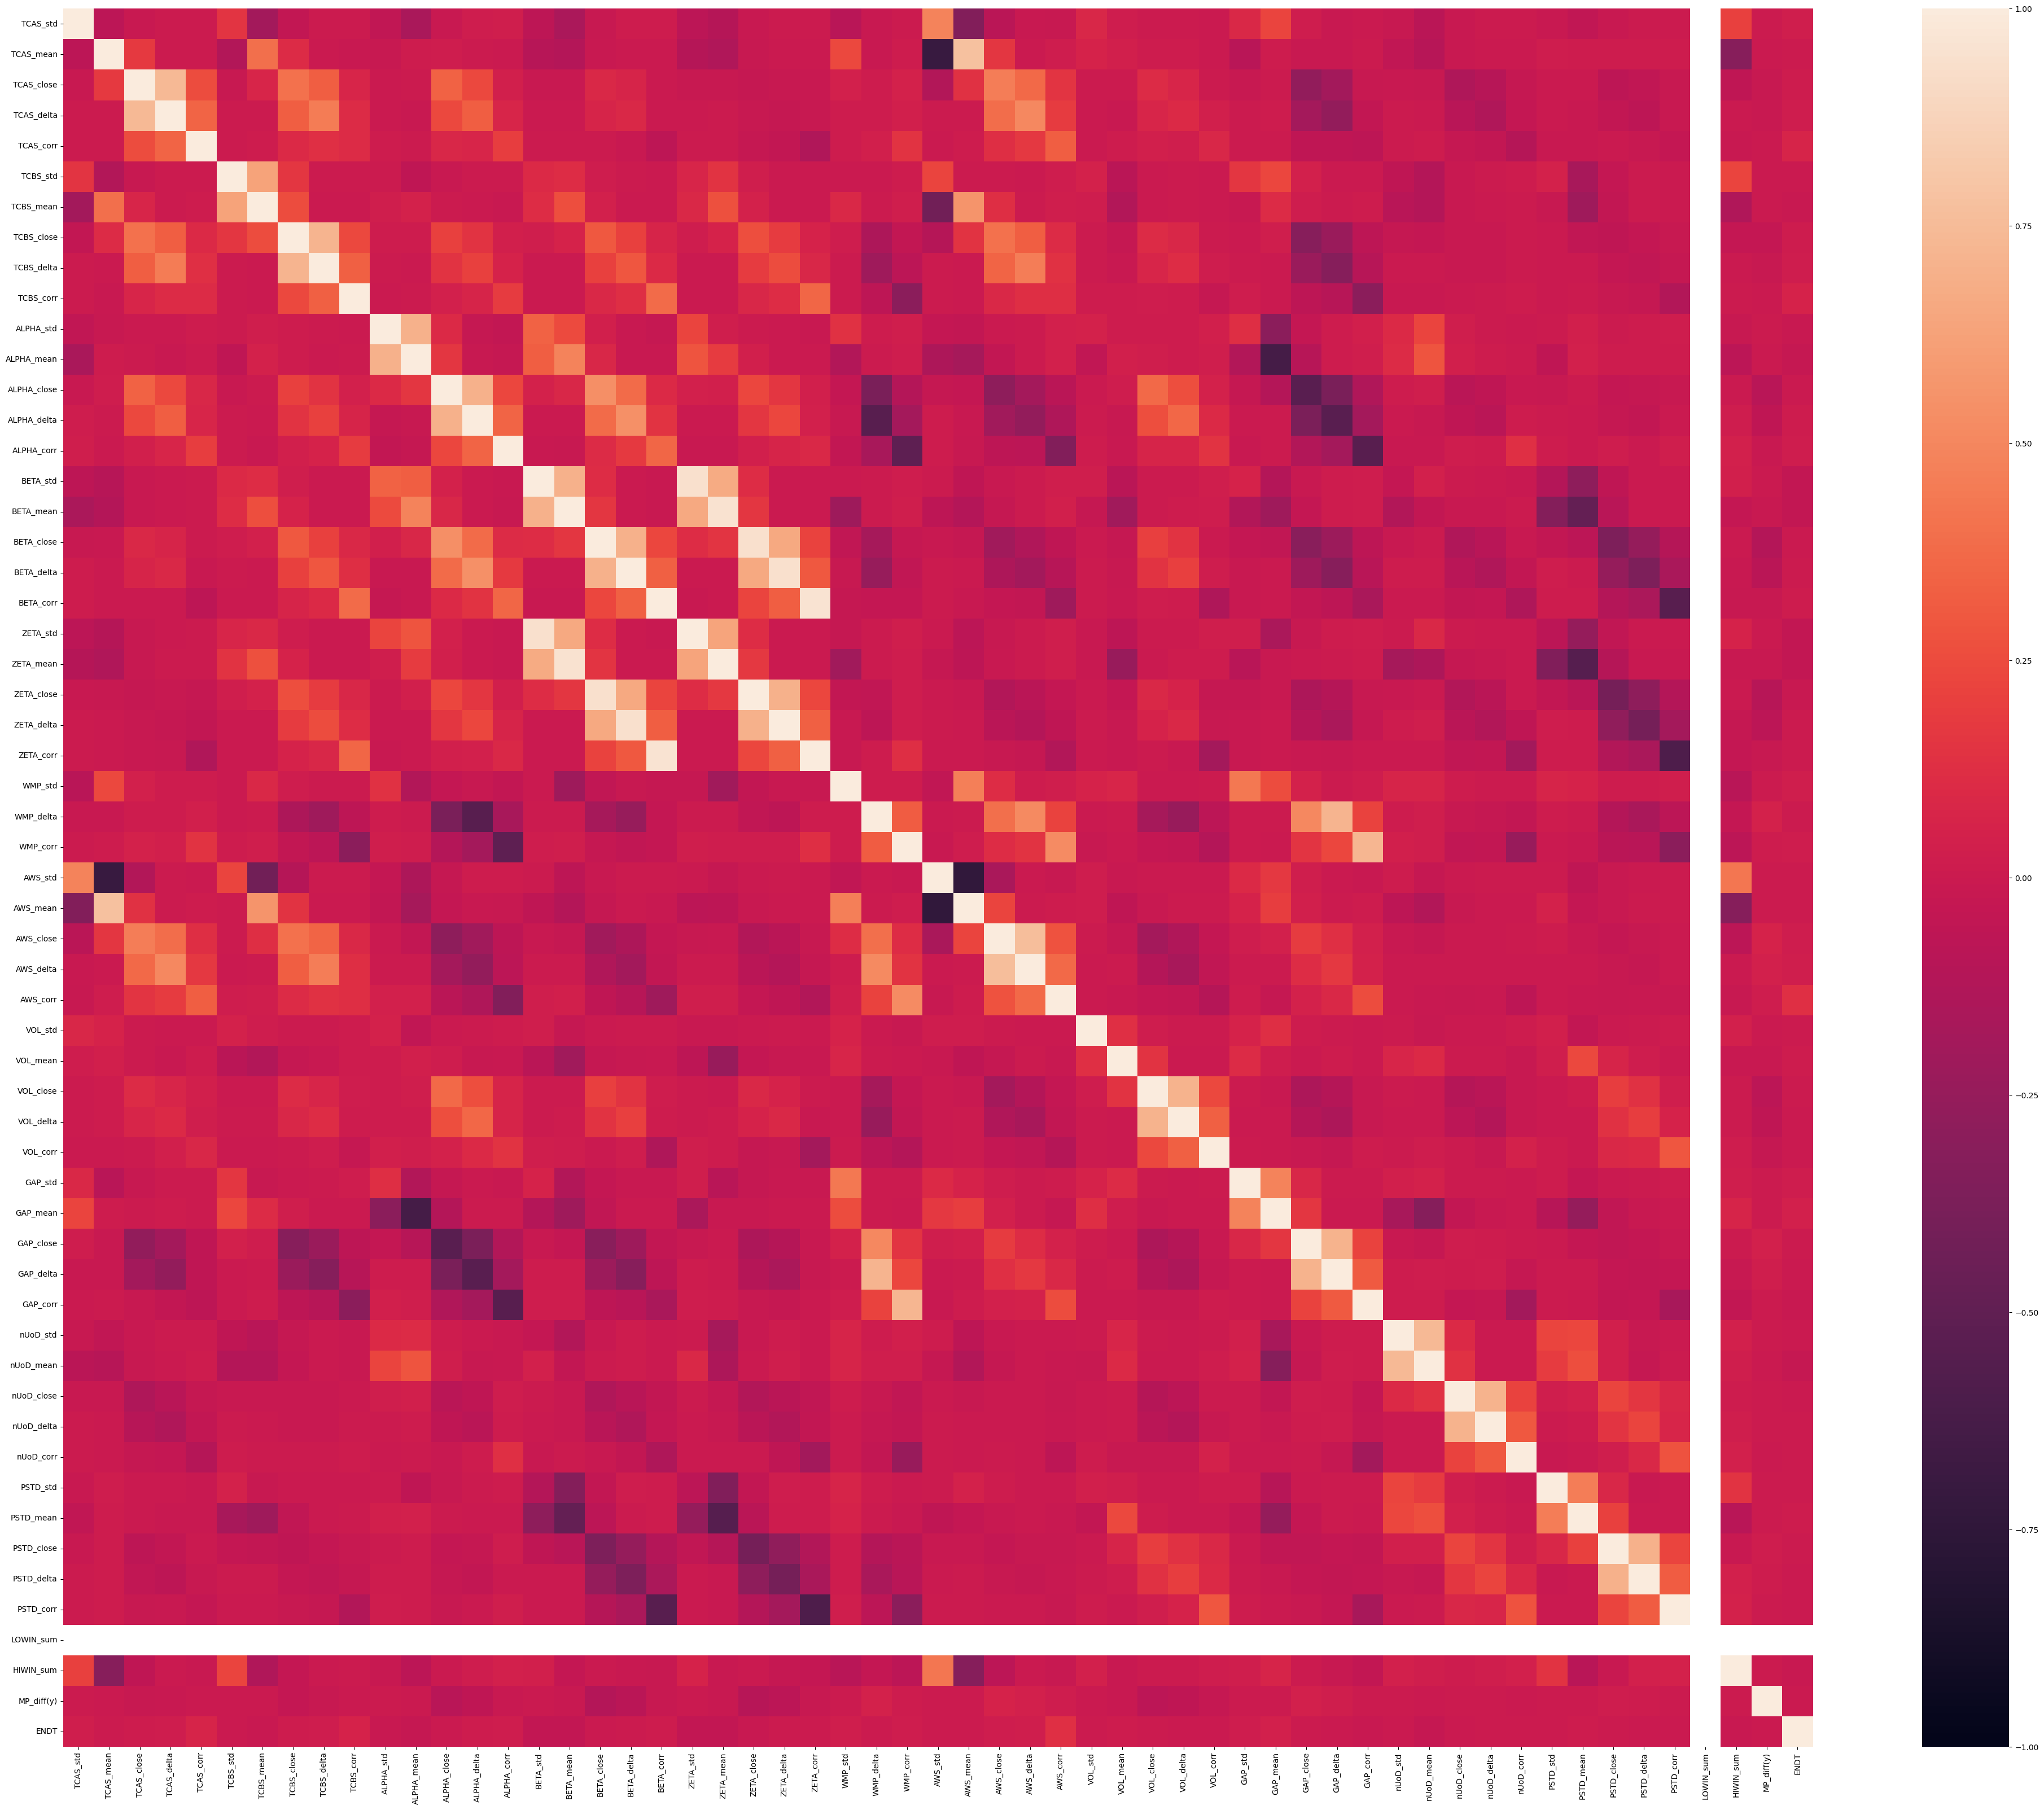

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

merged_dfs = pd.read_csv("final_merged_15s.csv", index_col=0)
plt.figure(figsize=(50,40))
sns.heatmap(merged_dfs.corr(), vmin = -1, vmax = 1)

C:\Users\wwden\AppData\Local\Temp\ipykernel_23208\3813475756.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dfs[col] = (clean_dfs[col] - mean) / std


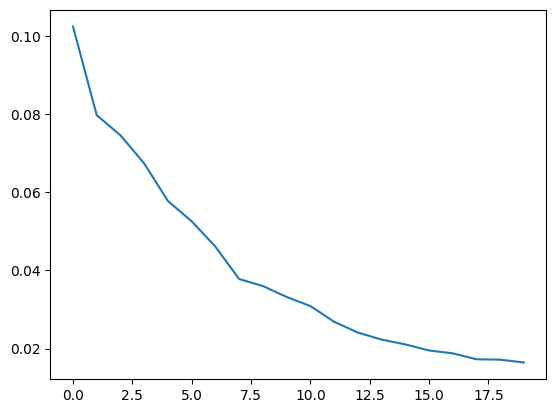

In [22]:
from sklearn.decomposition import PCA

merged_dfs = pd.read_csv("final_merged_15s.csv", index_col=0)
x_features = list(merged_dfs)
x_features.remove("MP_diff(y)")
x_features.remove("LOWIN_sum")

clean_dfs = merged_dfs.dropna(how="any")

for col in x_features:
    std = clean_dfs[col].std()
    mean = clean_dfs[col].mean()

    clean_dfs[col] = (clean_dfs[col] - mean) / std

pca = PCA(n_components=20)
pca_results = pca.fit_transform(clean_dfs[x_features])

plt.plot(pca.explained_variance_ratio_)

c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


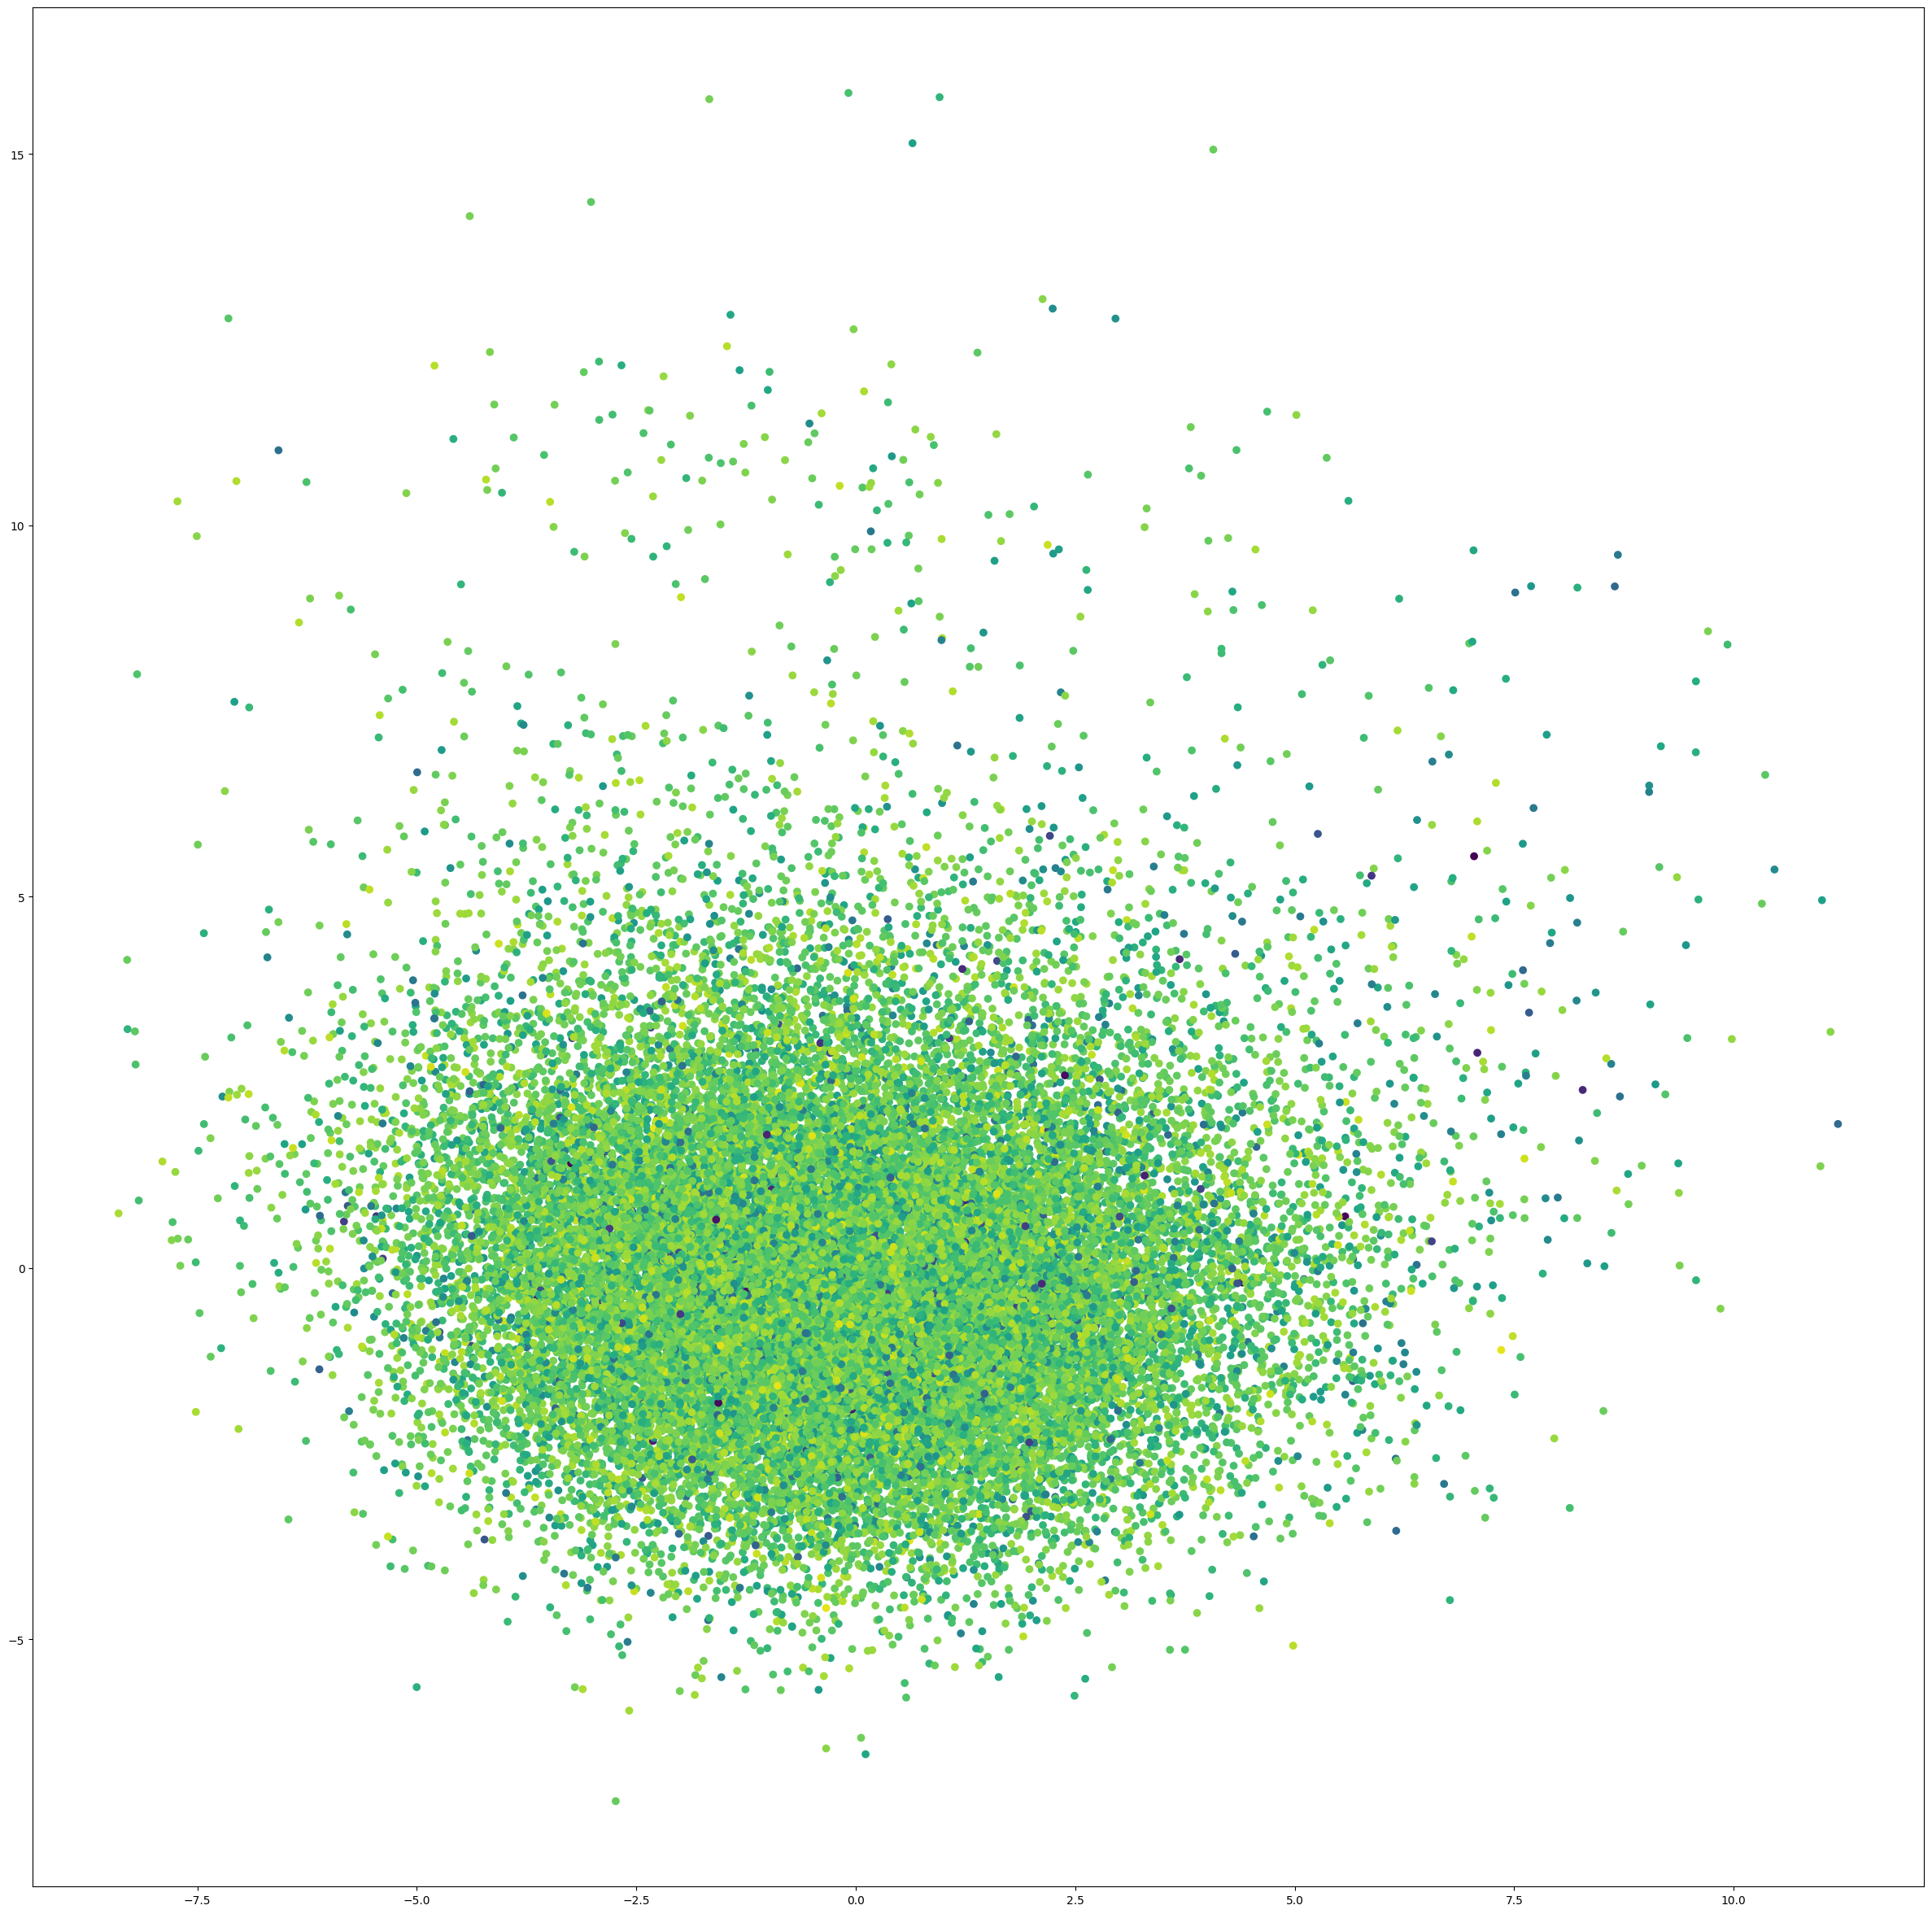

In [26]:
import numpy as np
plt.figure(figsize=(30,30))
plt.scatter(pca_results[:,0], pca_results[:,1], c = np.log(clean_dfs["MP_diff(y)"]))